## Notebook to fit triple orbits with astrometry + rv

In [25]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import matplotlib.cm as cm
from read_data import read_data,read_rv,read_wds,read_orb6
from astrometry_model import astrometry_model,binary_model_combined,astrometry_model_vlti,rv_model,rv_model_circular,triple_model,triple_model_circular,triple_model_combined,triple_model_vlti_combined,triple_model_vlti,triple_model_combined_circular,lnlike,lnprior,lnpost,create_init
from orbit_plotting import orbit_model,triple_orbit_model
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import random
from PyAstronomy.pyasl import foldAt
from PyAstronomy import pyasl
from uncertainties import ufloat,umath
from uncertainties.umath import *
import emcee
import corner
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
ks=pyasl.MarkleyKESolver()

%matplotlib inline

In [30]:
## setup paths for user
path = '/Users/tgardner/ARMADA_orbits/'
path_etalon = '/Users/tgardner/etalon_epochs/etalon_fits/etalon_factors_fit.txt'
path_wds = '/Users/tgardner/ARMADA_orbits/'
path_orb6 = '/Users/tgardner/catalogs/orb6orbits.sql.txt'

In [31]:
## Specify target
target_hd = '283868' ## HD number
note = 'exclude_nov' ## note for saved file
corrected = 'n' ## bootstrap errors?

In [32]:
query = Simbad.query_objectids('HD %s'%target_hd)
for item in query:
    if 'HIP' in item[0]:
        target = item[0].split()[1]
        print('HIP %s'%target)
    if 'WDS' in item[0]:
        target_wds = item[0][5:15]
        print('WDS %s'%target_wds)

In [33]:
#target_wds = '09320-0111'

In [34]:
###########################################
## Read in ARMADA data
###########################################
if corrected == 'y':
    print('reading boostrap errors')
    file=open('%s/HD_%s_bootstrap.txt'%(path,target_hd))
else:
    print('reading chi2 errors')
    file=open('%s/HD_%s_chi2err.txt'%(path,target_hd))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

file_rv=open('%s/HD_%s_rv.txt'%(path,target_hd))

weight_rv = 11.5 ## km/s error

t_rv,rv,err_rv = read_rv(file_rv,weight_rv)
t_rv-=2400000
file_rv.close()

err_rv[:]=weight_rv

reading chi2 errors


MJD? (y,[n]):  n


In [35]:
## print rv for paper
print('HJD RV err')
for i,j,k in zip(t_rv,rv,err_rv):
    print('%s & %s & %s \\\\'%(i,j,k))

HJD RV err
55091.16000000015 & 31.04 & 11.5 \\
55091.189999999944 & 31.1 & 11.5 \\
55094.12000000011 & 28.84 & 11.5 \\
55094.12999999989 & 27.59 & 11.5 \\
55101.22999999998 & 17.39 & 11.5 \\
55124.16000000015 & 40.85 & 11.5 \\
55131.16000000015 & 47.87 & 11.5 \\
55206.950000000186 & 53.34 & 11.5 \\
55214.939999999944 & 58.36 & 11.5 \\
55221.89000000013 & 36.64 & 11.5 \\
55474.220000000205 & 43.05 & 11.5 \\
55474.25 & 43.12 & 11.5 \\
55498.18000000017 & 20.62 & 11.5 \\
55507.0 & 35.7 & 11.5 \\
55544.14999999991 & 32.51 & 11.5 \\
55575.060000000056 & 19.42 & 11.5 \\
55580.87000000011 & 23.27 & 11.5 \\
55619.87000000011 & 26.12 & 11.5 \\
55640.89000000013 & 46.6 & 11.5 \\
55650.85999999987 & 15.04 & 11.5 \\
55777.220000000205 & 23.16 & 11.5 \\
55779.22999999998 & 23.35 & 11.5 \\
55786.20999999996 & 28.4 & 11.5 \\
55795.22999999998 & 35.34 & 11.5 \\
55800.200000000186 & 39.38 & 11.5 \\
55807.169999999925 & 23.26 & 11.5 \\
55828.24000000022 & 34.95 & 11.5 \\
55835.200000000186 & 45.4 & 11.5

In [36]:
#t_rv = t_rv-2400000

In [37]:
###########################################
## Apply etalon correction
###########################################
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    if min(abs(i-mjd_etalon))>0.5:
        print('Closest factor for %s is %s days away'%(i,min(abs(i-mjd_etalon))))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

Closest factor for 58708.49005816945 is 5.447116478346288 days away
Closest factor for 58709.50278853055 is 6.459846839446982 days away
Closest factor for 58775.399969019774 is 5.382230107548821 days away
Closest factor for 58777.3852281177 is 7.367489205476886 days away
Closest factor for 59826.50685138748 is 37.576949724694714 days away
Closest factor for 59826.50685138748 is 37.576949724694714 days away
Closest factor for 60188.446183902415 is 55.922930735621776 days away
   date      etalon factor
58708.49005816945 1.0007788200839338
58709.50278853055 1.0007788200839338
58775.399969019774 1.0008500320628442
58777.3852281177 1.0008500320628442
59826.50685138748 0.9999385610630156
59826.50685138748 0.9999385610630156
60188.446183902415 1.0014401680188312


In [38]:
## set etalon factors to 1 for vlti data
vlti = 'n'
if vlti=='y':
    vlti_idx = input('enter indices (e.g. 1 2 3): ').split(' ')
    vlti_idx = np.array([int(i) for i in vlti_idx])
else:
    vlti_idx = []
    
## Apply etalon
etalon = 'n'
if etalon=='y':
    print('Applying etalon correction')
    if len(vlti_idx)>0:
        print('Setting VLTI correction factors to 1.0')
        etalon_factor[vlti_idx] = 1.0
    p = p/etalon_factor
else:
    print('No etalon correction applied')

No etalon correction applied


In [39]:
xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

vlti_mask = np.ones(len(t),dtype=bool)
vlti_mask[vlti_idx] = False

In [40]:
## print rv for paper
print('MJD xpos ypos xerr yerr')
for i,j,k,l,m in zip(t,xpos,ypos,error_maj,error_min):
    print('%s & %s & %s & %s & %s \\\\'%(i,j,k,l,m))

MJD xpos ypos xerr yerr
58708.49005816945 & -0.7997614936516149 & -0.6233598906507686 & 0.004 & 0.004 \\
58709.50278853055 & -0.7586709233961064 & -0.6560696837938017 & 0.005 & 0.005 \\
58775.399969019774 & -0.09223356109474239 & -1.0840834701293913 & 0.008 & 0.008 \\
58777.3852281177 & -0.05797401880009952 & -1.1385249286441494 & 0.006 & 0.006 \\
59826.50685138748 & -1.335995486390326 & 0.34571094912466344 & 0.003 & 0.003 \\
59826.50685138748 & -1.2952714826368696 & 0.32325962672082253 & 0.003 & 0.003 \\
60188.446183902415 & 1.851057037173142 & -0.9639278215363375 & 0.02 & 0.02 \\


In [41]:
###########################################
## Read in WDS data - and plot to check
###########################################
input_wds = 'n'
if input_wds == 'y':
    file=open(os.path.expanduser("%s/HD%s_chi2err/HD_%s_wds.txt"%(path_wds,target_hd,target_hd)))
    weight = 1
    t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_data(file,weight)
    print('Number of WDS data points = %s'%len(p_wds))

    ## correct WDS for PA
    #theta_wds -= (0.00557*np.sin(ra)/np.cos(dec)*((t_wds-51544.5)/365.25))/180*np.pi

    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    idx = np.argmin(t)

    plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
    plt.plot(xpos_wds[0],ypos_wds[0],'*')
    plt.plot(xpos[idx],ypos[idx],'*')
    if len(vlti_idx)>0:
        plt.plot(xpos[vlti_mask],ypos[vlti_mask],'+',label='ARMADA-CHARA')
        plt.plot(xpos[vlti_idx],ypos[vlti_idx],'+',label='ARMADA-VLTI')
    else:
        plt.plot(xpos,ypos,'+',label='ARMADA')
    plt.plot(0,0,'*')
    plt.gca().invert_xaxis()
    plt.title('All Data')
    plt.xlabel('dra (mas)')
    plt.ylabel('ddec (mas)')
    plt.legend()
    plt.show()

    flip = input('Flip WDS data? (y/n): ')
    if flip=='y':
        xpos_wds=-p_wds*np.sin(theta_wds)
        ypos_wds=-p_wds*np.cos(theta_wds)
        plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
        plt.plot(xpos_wds[0],ypos_wds[0],'*')
        plt.plot(xpos[idx],ypos[idx],'*')
        plt.plot(xpos,ypos,'+',label='ARMADA')
        plt.plot(0,0,'*')
        plt.gca().invert_xaxis()
        plt.title('All Data')
        plt.xlabel('dra (mas)')
        plt.ylabel('ddec (mas)')
        plt.legend()
        plt.show()

        better = input('Flip data back to original? (y/n): ')
        if better=='y':
            xpos_wds=p_wds*np.sin(theta_wds)
            ypos_wds=p_wds*np.cos(theta_wds)
else:
    t_wds = np.array([np.nan])
    p_wds = np.array([np.nan])
    theta_wds = np.array([np.nan])
    error_maj_wds = np.array([np.nan])
    error_min_wds = np.array([np.nan])
    error_pa_wds = np.array([np.nan])
    error_deg_wds = np.array([np.nan])
    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    print('NO WDS DATA')

NO WDS DATA


In [42]:
###########################################
## Get an estimate of the orbital parameters
###########################################
try:
    a,P,e,inc,omega,bigomega,T = read_orb6(target,path_orb6)
except:
    print('No elements found in ORB6')
    
self_params = 'y'
if self_params=='y':
    a = float(input('a (mas): '))
    P = float(input('P (year): '))*365.25
    e = float(input('ecc : '))
    inc = float(input('inc (deg): '))
    omega = float(input('omega (deg): '))
    bigomega = float(input('bigomega (deg): '))
    T = float(input('T (mjd): '))
    

No elements found in ORB6


a (mas):  1.9
P (year):  3.3
ecc :  0.2
inc (deg):  136
omega (deg):  71
bigomega (deg):  310
T (mjd):  55082


In [43]:
###########################################
## Combined WDS+ARMADA for fitting
###########################################
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])
error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

vlti_mask_all = np.ones(len(t_all),dtype=bool)
vlti_mask_all[vlti_idx] = False

In [44]:
##########################################
## Function for fitting/plotting data
#########################################
def ls_fit(params,xp,yp,tp,emaj,emin,epa):
    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        minner = Minimizer(astrometry_model_vlti, params, fcn_args=(xp[vlti_mask_all],yp[vlti_mask_all],tp[vlti_mask_all],
                                                        emaj[vlti_mask_all],emin[vlti_mask_all],epa[vlti_mask_all],
                                                        xp[vlti_idx],yp[vlti_idx],tp[vlti_idx],
                                                        emaj[vlti_idx],emin[vlti_idx],epa[vlti_idx]),
                                nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(astrometry_model, params, fcn_args=(xp,yp,tp,
                                                        emaj,emin,epa),
                                nan_policy='omit')
        result = minner.minimize()

    # write error report
    print(report_fit(result))

    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                 error_min,error_pa)
    resids_wds = astrometry_model(result.params,xpos_wds,ypos_wds,t_wds,error_maj_wds,
                                 error_min_wds,error_pa_wds)
    ndata_armada = 2*sum(~np.isnan(xpos))
    ndata_wds = 2*sum(~np.isnan(xpos_wds))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
    chi2_wds = np.nansum(resids_wds**2)/(ndata_wds-7)
    print('-'*10)
    print('chi2 armada = %s'%chi2_armada)
    print('-'*10)
    print('chi2 wds = %s'%chi2_wds)
    print('-'*10)

    ## plot fit
    scale=1
    if chi2_armada<1.0 and chi2_armada>0:
        scale=1/np.sqrt(chi2_armada)
    a_start = result.params['a']
    P_start = result.params['P']
    e_start = result.params['e']
    inc_start = result.params['inc']
    w_start = result.params['w']
    bigw_start = result.params['bigw']
    T_start = result.params['T']
    mirc_scale_start = result.params['mirc_scale']

    ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                            w_start,bigw_start,P_start,
                                            T_start,t_all)
    fig,ax=plt.subplots()
    ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
    if len(vlti_idx)>0:
        ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
        ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
    else:
        ax.plot(xpos,ypos,'o', label='ARMADA')
    ax.plot(0,0,'*')
    ax.plot(ra, dec, '--',color='g')
    #plot lines from data to best fit orbit
    i=0
    while i<len(decpoints):
        x=[xpos_all[i],rapoints[i]]
        y=[ypos_all[i],decpoints[i]]
        ax.plot(x,y,color="black")
        i+=1
    ax.set_xlabel('milli-arcsec')
    ax.set_ylabel('milli-arcsec')
    ax.invert_xaxis()
    ax.axis('equal')
    ax.set_title('HD%s Outer Orbit'%target_hd)
    plt.legend()
    plt.show()

    return result

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 14
    # variables        = 7
    chi-square         = 206.509435
    reduced chi-square = 29.5013479
    Akaike info crit   = 51.6780428
    Bayesian info crit = 56.1514441
[[Variables]]
    w:           62.0205569 +/- 15.6575978 (25.25%) (init = 71)
    bigw:        300.392616 +/- 7.73043264 (2.57%) (init = 310)
    inc:         137.960489 +/- 2.46478337 (1.79%) (init = 136)
    e:           0.30556773 +/- 0.01765563 (5.78%) (init = 0.2)
    a:           1.90001836 +/- 0.04154890 (2.19%) (init = 1.9)
    P:           1210.69161 +/- 4.78907504 (0.40%) (init = 1205.325)
    T:           55055.9322 +/- 27.7872079 (0.05%) (init = 55082)
    mirc_scale:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, bigw)   = 0.941
    C(w, T)      = 0.892
    C(bigw, T)   = 0.849
    C(P, T)      = -0.830
    C(bigw, e)   = -0.691
    C(inc, a)    = -0.636
    C(bigw, P)   

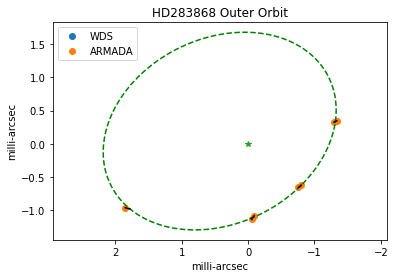

In [45]:
###########################################
## Do a least-squares fit -- VISUAL ONLY
###########################################
params = Parameters()
params.add('w',   value= omega, min=0, max=360)
params.add('bigw', value= bigomega, min=0, max=360)
params.add('inc', value= inc, min=0, max=180)
params.add('e', value= e, min=0, max=0.99)
params.add('a', value= a, min=0)
params.add('P', value= P, min=0)
params.add('T', value= T, min=0)
if len(vlti_idx)>0:
    params.add('mirc_scale', value=1)
else:
    params.add('mirc_scale',value=1,vary=False)

result = ls_fit(params,xpos_all,ypos_all,t_all,error_maj_all,error_min_all,error_pa_all)

In [46]:
## scale errors to fit again
chara_scale = 1 / np.sqrt(29.5)
vlti_scale = 1
wds_scale = 1/np.sqrt(1)

if len(vlti_idx)>0:
    error_maj[vlti_idx]/=vlti_scale
    error_min[vlti_idx]/=vlti_scale
    error_maj_all[vlti_idx]/=vlti_scale
    error_min_all[vlti_idx]/=vlti_scale
    
    error_maj[vlti_mask]/=chara_scale
    error_min[vlti_mask]/=chara_scale
    error_maj_all[vlti_mask_all]/=chara_scale
    error_min_all[vlti_mask_all]/=chara_scale
    
    error_maj_wds/=wds_scale
    error_min_wds/=wds_scale
    error_maj_all[len(xpos):]/=wds_scale
    error_min_all[len(xpos):]/=wds_scale
    
else:
    error_maj/=chara_scale
    error_min/=chara_scale
    error_maj_all[:len(error_maj)]/=chara_scale
    error_min_all[:len(error_maj)]/=chara_scale
    
    error_maj_wds/=wds_scale
    error_min_wds/=wds_scale
    error_maj_all[len(xpos):]/=wds_scale
    error_min_all[len(xpos):]/=wds_scale

In [ ]:
1/(0.1*1/np.sqrt(0.03636763))

----------
chi2 armada = 1.000045689922296
----------


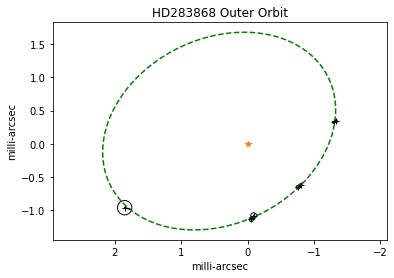

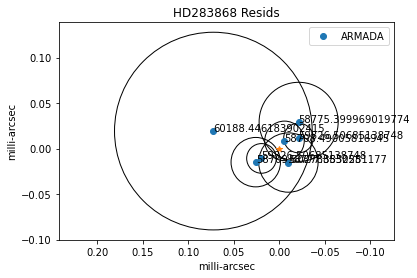

----------
Mean residual = 24.0 micro-as
----------


In [47]:
##########################################
## Save Plots
##########################################
if len(vlti_idx)>0:
    resids_armada = astrometry_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

if corrected == 'y':
    directory='%s/HD%s_bootstrap_triple/'%(path,target_hd)
else:
    directory='%s/HD%s_chi2err_triple/'%(path,target_hd)
if not os.path.exists(directory):
    os.makedirs(directory)

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
mirc_scale_start = result.params['mirc_scale']
ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)
fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'+', label='ARMADA',color='black',markersize=6)
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xpos,ypos,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    #ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
#plt.legend()
plt.savefig('%s/HD%s_%s_outer_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
if len(vlti_idx)>0:
    xresid_vlti = xpos[vlti_idx]*mirc_scale_start - rapoints[:len(xpos)][vlti_idx]
    yresid_vlti = ypos[vlti_idx]*mirc_scale_start - decpoints[:len(ypos)][vlti_idx]
    xresid_chara = xpos[vlti_mask] - rapoints[:len(xpos)][vlti_mask]
    yresid_chara = ypos[vlti_mask] - decpoints[:len(ypos)][vlti_mask]
    xresid = np.concatenate([xresid_chara,xresid_vlti])
    yresid = np.concatenate([yresid_chara,yresid_vlti])
else:
    xresid = xpos - rapoints[:len(xpos)]
    yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_binary.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) mirc_scale mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s"%(P_start.value,a_start.value,e_start.value,
                                   inc_start.value*180/np.pi,w_start.value*180/np.pi,
                                   bigw_start.value*180/np.pi,T_start.value,
                                  mirc_scale_start.value,resids_median))
f.close()

## Include RV

In [ ]:
## randomize orbital elements:
guess_params = 'y'
if guess_params=='y':

    astart = 2
    aend = 5
    Pstart = 3*365
    Pend = 4*365

    w_results = []
    bigw_results = []
    inc_results = []
    e_results = []
    a_results = []
    P_results = []
    T_results = []
    mirc_scale_results = []
    chi2_results = []
    K_results = []
    gamma_results = []

    for s in tqdm(np.arange(200)):
        x1 = random.uniform(0,360)
        x2 = random.uniform(0,360)
        #x3 = random.uniform(0,180)
        x3 = 120
        x4 = random.uniform(0,0.9)
        x5 = random.uniform(astart,aend)
        x6 = random.uniform(Pstart,Pend)
        #x7 = random.uniform(30000,80000)
        x7 = random.uniform(58500,60000)
        
        x8 = random.uniform(-30,30)
        x9 = random.uniform(-30,30)

        params = Parameters()
        params.add('w',   value= x1, min=0, max=360)
        params.add('bigw', value= x2, min=0, max=360)
        params.add('inc', value= x3, vary=False)#min=0, max=180)
        params.add('e', value= x4, min=0, max=0.99)
        params.add('a', value= x5, min=0)
        params.add('P', value= x6, min=0)
        params.add('T', value= x7, min=0)
        params.add('K', value= x8)
        params.add('gamma', value= x9)
        if len(vlti_idx)>0:
            params.add('mirc_scale', value=1)
        else:
            params.add('mirc_scale',value=1,vary=False)

        #do fit, minimizer uses LM for least square fitting of model to data
        minner = Minimizer(binary_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                    error_maj_all,error_min_all,
                                                    error_pa_all,rv,t_rv,err_rv),
                    nan_policy='omit')
        result = minner.minimize()

        w_results.append(result.params['w'].value)
        bigw_results.append(result.params['bigw'].value)
        inc_results.append(result.params['inc'].value)
        e_results.append(result.params['e'].value)
        a_results.append(result.params['a'].value)
        P_results.append(result.params['P'].value)
        T_results.append(result.params['T'].value)
        mirc_scale_results.append(result.params['mirc_scale'].value)
        chi2_results.append(result.redchi)
        gamma_results.append(result.params['gamma'].value)
        K_results.append(result.params['K'].value)

    w_results = np.array(w_results)
    bigw_results = np.array(bigw_results)
    inc_results = np.array(inc_results)
    e_results = np.array(e_results)
    a_results = np.array(a_results)
    P_results = np.array(P_results)
    T_results = np.array(T_results)
    mirc_scale_results = np.array(mirc_scale_results)
    chi2_results = np.array(chi2_results)
    gamma_results = np.array(gamma_results)
    K_results = np.array(K_results)

    idx = np.argmin(chi2_results)
    w_start = w_results[idx]
    bigw_start = bigw_results[idx]
    inc_start = inc_results[idx]
    e_start = e_results[idx]
    a_start = a_results[idx]
    P_start = P_results[idx]
    T_start = T_results[idx]
    gamma_start = gamma_results[idx]
    K_start = K_results[idx]
    mirc_scale_start = mirc_scale_results[idx]

    print('P, a, e, inc, w, bigw, T, K, gamma, mirc_scale: ')
    print(P/365, a_start, e_start, inc_start, w_start, bigw_start, T_start, K_start, gamma_start, mirc_scale_start)

In [48]:
###########################################
## Do a least-squares fit -- VISUAL ONLY
###########################################
params = Parameters()

params.add('w',   value= w_start.value, min=0, max=360)
params.add('bigw', value= bigw_start.value, min=0, max=360)
params.add('inc', value= inc_start.value, min=0, max=180)
params.add('e', value= e_start.value, min=0, max=0.99)
params.add('a', value= a_start.value, min=0)
params.add('P', value= P_start.value, min=0)
params.add('T', value= T_start.value, min=0)

#params.add('w',   value= 97, min=0, max=360)
#params.add('bigw', value= 311, min=0, max=360)
#params.add('inc', value= 139, min=0, max=180)
#params.add('e', value= 0.3, min=0, max=0.99)
#params.add('a', value= 1.8, min=0)
#params.add('P', value= 3.4*365, min=0)
#params.add('T', value= 58736.04, min=0)

if len(vlti_idx)>0:
    params.add('mirc_scale', value=1)
else:
    params.add('mirc_scale',value=1,vary=False)

params.add('K',value=15)
params.add('gamma',value=30)


In [49]:
minner = Minimizer(binary_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                    error_maj_all,error_min_all,
                                                    error_pa_all,rv,t_rv,err_rv),
                    nan_policy='omit')
result = minner.minimize()
report_fit(result)
    
P_best = result.params['P'].value
a_best = result.params['a'].value
e_best = result.params['e'].value
w_best = result.params['w'].value
bigw_best = result.params['bigw'].value
inc_best = result.params['inc'].value
T_best = result.params['T'].value
K_best = result.params['K'].value
gamma_best = result.params['gamma'].value
mirc_scale_best = result.params['mirc_scale'].value

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 153
    # variables        = 9
    chi-square         = 153.634146
    reduced chi-square = 1.06690379
    Akaike info crit   = 18.6328356
    Bayesian info crit = 45.9067769
[[Variables]]
    w:           84.6085075 +/- 10.3370217 (12.22%) (init = 62.02056)
    bigw:        310.241354 +/- 5.25726328 (1.69%) (init = 300.3926)
    inc:         138.724814 +/- 2.87136468 (2.07%) (init = 137.9605)
    e:           0.29204115 +/- 0.01566464 (5.36%) (init = 0.3055677)
    a:           1.87903608 +/- 0.04769259 (2.54%) (init = 1.900018)
    P:           1209.92965 +/- 4.56130595 (0.38%) (init = 1210.692)
    T:           55083.7216 +/- 21.9545007 (0.04%) (init = 55055.93)
    mirc_scale:  1 (fixed)
    K:           11.8668697 +/- 1.63750926 (13.80%) (init = 15)
    gamma:       31.6433974 +/- 1.05179300 (3.32%) (init = 30)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, big

----------
chi2 armada = 1.363634599263629
----------


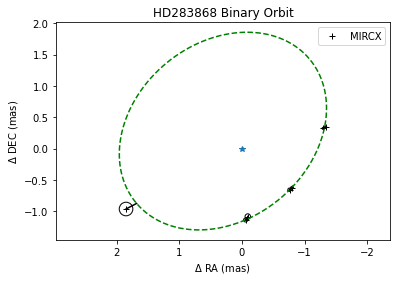

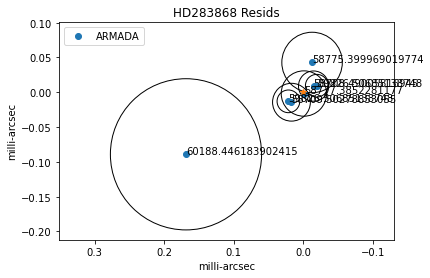

----------
Mean residual = 22.21 micro-as
----------


In [50]:
##########################################
## Save Plots
##########################################
if len(vlti_idx)>0:
    resids_armada = astrometry_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
ra,dec,rapoints,decpoints = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all)
fig,ax=plt.subplots()
#ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx]*mirc_scale_best,ypos[vlti_idx]*mirc_scale_best,'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'+', label='MIRCX',color='black')
    #ax.plot(xpos[5],ypos[5],'.', label='MYSTIC',color='red')
    #ax.plot(xpos[-1],ypos[-1],'o', label='GRAVITY',color='blue')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xpos,ypos,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    #ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('$\Delta$ RA (mas)')
ax.set_ylabel('$\Delta$ DEC (mas)')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Binary Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
if len(vlti_idx)>0:
    xresid_vlti = xpos[vlti_idx]*mirc_scale_best - rapoints[:len(xpos)][vlti_idx]
    yresid_vlti = ypos[vlti_idx]*mirc_scale_best - decpoints[:len(ypos)][vlti_idx]
    xresid_chara = xpos[vlti_mask] - rapoints[:len(xpos)][vlti_mask]
    yresid_chara = ypos[vlti_mask] - decpoints[:len(ypos)][vlti_mask]
    xresid = np.concatenate([xresid_chara,xresid_vlti])
    yresid = np.concatenate([yresid_chara,yresid_vlti])
else:
    xresid = xpos - rapoints[:len(xpos)]
    yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_binary.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) mirc_scale mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s"%(P_best,a_best,e_best,
                                   inc_best*180/np.pi,w_best*180/np.pi,
                                   bigw_best*180/np.pi,T_best,
                                  mirc_scale_best,resids_median))
f.close()

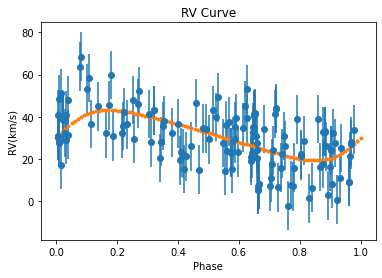

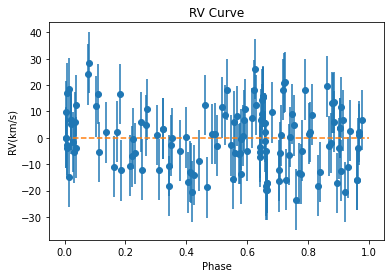

11.708611815071963


In [51]:
#Plot RV results:
w_rv = w_best*np.pi/180#+np.pi
foldtime= foldAt(t_rv,P_best,T0=T_best)
tt=np.linspace(T_best,T_best+P_best,100)
MM=[]
for i in tt:
    mm_anom=2*np.pi/P_best*(i-T_best)
    MM.append(mm_anom)
MM=np.asarray(MM)
EE=[]
for j in MM:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e_best)
    EE.append(ee_anom)
EE=np.asarray(EE)
MM2=[]
for i in t_rv:
    mm_anom=2*np.pi/P_best*(i-T_best)
    MM2.append(mm_anom)
MM2=np.asarray(MM2)
EE2=[]

for j in MM2:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e_best)
    EE2.append(ee_anom)
EE2=np.asarray(EE2)

f=2*np.arctan(np.sqrt((1+e_best)/(1-e_best))*np.tan(EE/2))
y1=-K_best*(np.cos(w_rv+f)+e_best*np.cos(w_rv))+gamma_best
tt_fold=foldAt(tt,P_best,T0=T_best)

fpoints=2*np.arctan(np.sqrt((1+e_best)/(1-e_best))*np.tan(EE2/2))
y1points=-K_best*(np.cos(w_rv+fpoints)+e_best*np.cos(w_rv))+gamma_best

plt.errorbar(foldtime,rv,yerr=err_rv,fmt='o')
plt.plot(tt_fold,y1,'.')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

plt.errorbar(foldtime,rv-y1points,yerr=err_rv,fmt='o')
plt.plot([0,1],[0,0],'--')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_resids_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

print(np.nanstd(rv-y1points))

In [52]:
resids = rv-y1points


In [ ]:
#Plot RV results:
w_rv = 0*np.pi/180+np.pi
foldtime= foldAt(t_rv,4.6,T0=58576.99)
tt=np.linspace(58576.99,58576.99+4.6,100)
MM=[]
for i in tt:
    mm_anom=2*np.pi/4.6*(i-58576.99)
    MM.append(mm_anom)
MM=np.asarray(MM)
EE=[]
for j in MM:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,0)
    EE.append(ee_anom)
EE=np.asarray(EE)
MM2=[]
for i in t_rv:
    mm_anom=2*np.pi/4.6*(i-58576.99)
    MM2.append(mm_anom)
MM2=np.asarray(MM2)
EE2=[]

for j in MM2:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,0)
    EE2.append(ee_anom)
EE2=np.asarray(EE2)

f=2*np.arctan(np.sqrt((1+0)/(1-0))*np.tan(EE/2))
y1=30*(np.cos(w_rv+f)+0*np.cos(w_rv))+0
tt_fold=foldAt(tt,4.6,T0=58576.99)

fpoints=2*np.arctan(np.sqrt((1+0)/(1-0))*np.tan(EE2/2))
y1points=30*(np.cos(w_rv+fpoints)+0*np.cos(w_rv))+0

plt.errorbar(foldtime,resids,yerr=err_rv,fmt='o')
plt.plot(tt_fold,y1,'.')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
#plt.savefig('%s/HD%s_%s_orbit_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
## Mass / Orbit Information

a_err = ufloat(result.params['a'].value,result.params['a'].stderr)
P_err = ufloat(result.params['P'].value,result.params['P'].stderr)
T_err = ufloat(result.params['T'].value,result.params['T'].stderr)
e_err = ufloat(result.params['e'].value,result.params['e'].stderr)
w_err = ufloat(result.params['w'].value,result.params['w'].stderr)
bigw_err = ufloat(result.params['bigw'].value,result.params['bigw'].stderr)
inc_err = ufloat(result.params['inc'].value,result.params['inc'].stderr)

K_err = ufloat(result.params['K'].value,result.params['K'].stderr)
gamma_err = ufloat(result.params['gamma'].value,result.params['gamma'].stderr)

## distance from HIP/GAIA
## AC Her
plx_hip = ufloat(0.00053,0.00140)
plx_gaia = ufloat(0.0007603,0.0000363)


print('Distance from HIP = ')
print(1/plx_hip)
print('Distance from GAIA = ')
print(1/plx_gaia)

d_err = 1/plx_gaia
#d_err = d_rv


In [ ]:
print('%s & %s & %s & %s & %s & %s & %s & %s'%(target_hd,P_err.nominal_value,a_err.nominal_value,
                                               e_err.nominal_value,inc_err.nominal_value,
                                               w_err.nominal_value,bigw_err.nominal_value,
                                               T_err.nominal_value))
print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s'%(P_err.std_dev,a_err.std_dev,
                                                                                  e_err.std_dev,inc_err.std_dev,w_err.std_dev,
                                                                                  bigw_err.std_dev,T_err.std_dev,))
print('--'*10)

if include_rv=='y':
    print('%s & %s & %s & %s & %s & %s & %s & %s & %s & %s'%(target_hd,P2_err.nominal_value,a2_err.nominal_value,
                                                             e2_err.nominal_value,inc2_err.nominal_value,
                                                             w2_err.nominal_value,bigw2_err.nominal_value,
                                                             T2_err.nominal_value,K_err.nominal_value,
                                                             gamma_err.nominal_value))
    print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s'%(P2_err.std_dev,
                                                                                                          a2_err.std_dev,e2_err.std_dev,
                                                                                                          inc2_err.std_dev,w2_err.std_dev,
                                                                                                          bigw2_err.std_dev,T2_err.std_dev,
                                                                                                          K_err.std_dev,gamma_err.std_dev,))
else:
    print('%s & %s & %s & %s & %s & %s & %s & %s & -- & --'%(target_hd,P2_err.nominal_value,a2_err.nominal_value,
                                                             e2_err.nominal_value,inc2_err.nominal_value,
                                                             w2_err.nominal_value,bigw2_err.nominal_value,
                                                             T2_err.nominal_value))
    print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & & '%(P2_err.std_dev,
                                                                                                          a2_err.std_dev,e2_err.std_dev,
                                                                                                          inc2_err.std_dev,w2_err.std_dev,
                                                                                                          bigw2_err.std_dev,T2_err.std_dev))

In [ ]:
d_err = 1/plx_gaia
#d_err = d_rv

print('-'*10)
print('Masses from distance')
print('-'*10)

sum1 = (a_err*d_err/1000)**3 / (P_err/365.25)**2
print('M1+M2 = %s Msun'%sum1)

In [ ]:
semi = a_err/1000*d_err
print('semi = %s au'%semi)